# Geospatial Analysis & Station Clustering
Objective: The goal is to analyze station usage by members through visualizations and clustering. This includes identifying the top stations by number of rides and creating clusters based on station usage. The insights gained will aid in planning for station expansion, upgrades, maintenance, and the placement of new stations.

Approach:
- Feature Selection: Number of rides starting at each station
- Feature Extraction: Ride Duration, Peak Usage Time
- Algorithm: K-Means

Steps

#### Import libraries

In [2]:
# Data manipulation packages
import pandas as pd
import numpy as np
import re

# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns 
import folium

# Math
from scipy import stats

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#### Import data

In [3]:
# Import all the monthly csv dataset
nov_20 = pd.read_csv(r"./202011-divvy-tripdata.csv")
dec_20 = pd.read_csv(r'./202012-divvy-tripdata.csv')
jan_21 = pd.read_csv(r'./202101-divvy-tripdata.csv')
feb_21 = pd.read_csv(r'./202102-divvy-tripdata.csv')
march_21 = pd.read_csv(r'./202103-divvy-tripdata.csv')
april_21 = pd.read_csv(r'./202104-divvy-tripdata.csv')
may_21 = pd.read_csv(r'./202105-divvy-tripdata.csv')
jun_21 = pd.read_csv(r'./202106-divvy-tripdata.csv')
july_21 = pd.read_csv(r'./202107-divvy-tripdata.csv')
aug_21 = pd.read_csv(r'./202108-divvy-tripdata.csv')
sept_21 = pd.read_csv(r'./202109-divvy-tripdata.csv')
oct_21 = pd.read_csv(r'./202110-divvy-tripdata.csv')
nov_21 = pd.read_csv(r'./202111-divvy-tripdata.csv')

# Join all months into a single dataframe
months = [nov_20, dec_20, jan_21, feb_21, march_21, april_21, may_21, jun_21, july_21, aug_21, sept_21, oct_21, nov_21]
df_months = pd.concat(months)


In [4]:
# Get basic information
df_months.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0,St. Clair St & Erie St,211.0,41.894177,-87.629127,41.894434,-87.623379,casual
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0,Noble St & Milwaukee Ave,29.0,41.890959,-87.635343,41.900675,-87.662480,casual
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0,Federal St & Polk St,41.0,41.880983,-87.616754,41.872054,-87.629550,casual
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0,Stave St & Armitage Ave,185.0,41.895499,-87.682013,41.917744,-87.691392,casual
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0,Buckingham Fountain,2.0,41.876497,-87.620358,41.876448,-87.620338,casual


In [5]:
# Check the number of data points
print(f'Number of data points: {df_months.shape[0]}')

# Check for duplicates
print(f'Number of duplicates {df_months.duplicated().sum()}')

# Check for missing values
df_months.isnull().sum()

Number of data points: 5738812
Number of duplicates 0


ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    675769
start_station_id      675876
end_station_name      725658
end_station_id        725735
start_lat                  0
start_lng                  0
end_lat                 5022
end_lng                 5022
member_casual              0
dtype: int64

In [6]:
# Drop the rows with missing values
df_months = df_months.dropna(axis=0).reset_index(drop=True)

# Check the number of data points after dropping missing values
print(f'Number of data points: {df_months.shape[0]}')

Number of data points: 4748631


#### Data Processing
- Convert data type
- Calculate ride duration

In [7]:
# Check data type
df_months.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748631 entries, 0 to 4748630
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 471.0+ MB


We need to convert the 'started_at and ended_at' string to a datetime. But to do that we need to make sure the string object are in the right format or else we get an error during conversion.

In [8]:
# Funtion to preprocess datetime string, adding seconds if missing
def preprocess_datetime(dt_str):
    if pd.isna(dt_str):
        return np.nan
    if len(dt_str) == 16:  # Format is missing seconds (YYYY-MM-DD HH:MM)
        return dt_str + ':00'
    # Add leading zero to single-digit hours
    if len(dt_str) == 15 and re.match(r'\d{4}-\d{2}-\d{2} \d:\d{2}', dt_str):
        return dt_str[:11] + '0' + dt_str[11:] + ':00'
    
    # Add leading zero to single-digit hours with missing seconds
    if len(dt_str) == 14 and re.match(r'\d{4}-\d{2}-\d{2} \d:\d{2}', dt_str):
        return dt_str[:11] + '0' + dt_str[11:] + ':00'
    return dt_str

# Apply the preprocessing function to both columns
df_months['started_at'] = df_months['started_at'].apply(preprocess_datetime)
df_months['ended_at'] = df_months['ended_at'].apply(preprocess_datetime)

# Convert to date time
df_months['started_at'] = pd.to_datetime(df_months['started_at'],format='%Y-%m-%d %H:%M:%S')
df_months['ended_at'] = pd.to_datetime(df_months['ended_at'],format='%Y-%m-%d %H:%M:%S')

#### Data Extraction

In [9]:
# start day of the week [Mon, Tue]
df_months['day'] = df_months['started_at'].dt.day_name()

# start time, from this we can determine if Morn, Afternoon, Night 
df_months['start_time'] = df_months['started_at'].dt.strftime('%H:%M:%S')
df_months['end_time'] = df_months['ended_at'].dt.strftime('%H:%M:%S') # Time when rides ended 

# month
df_months['month'] = df_months['started_at'].dt.strftime("%b-%y")

# Find the ride duration is seconds
df_months['ride_duration'] = (df_months['ended_at']-df_months['started_at']).dt.total_seconds()

# Get basic descriptive stats on the duration
df_months['ride_duration'].describe()

count    4.748631e+06
mean     1.197582e+03
std      1.776839e+04
min     -1.742998e+06
25%      4.200000e+02
50%      7.360000e+02
75%      1.335000e+03
max      3.356649e+06
Name: ride_duration, dtype: float64

#### Data Cleaning
For data cleaning, we will be using box plot

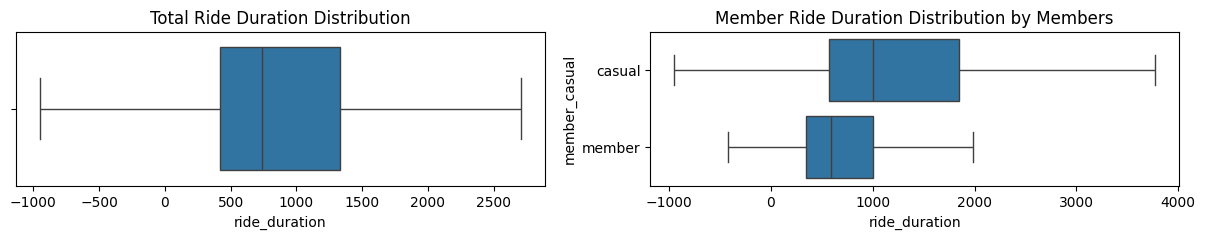

Interquartile range: 915.0
Lower Bound: -952.5
Upper Bound: 2707.5
Mean: 1197.582227804182


In [10]:
fig, axes = plt.subplots(1, 2, figsize = (15,2))

# Plot 1
sns.boxplot(ax=axes[0], x=df_months['ride_duration'], showfliers = False)
axes[0].set_title('Total Ride Duration Distribution')

# Plot 2
sns.boxplot(ax=axes[1], x = df_months['ride_duration'], y = df_months['member_casual'], showfliers = False)
axes[1].set_title('Member Ride Duration Distribution by Members')
plt.show()

p25 = df_months['ride_duration'].quantile(0.25) # 25th percentile
p50 = df_months['ride_duration'].quantile(0.5) # 50th percentile
p75 = df_months['ride_duration'].quantile(0.75) # 75th percentile

# Interquartile range
iqr = p75 - p25
print(f'Interquartile range: {iqr}')

# Lower Limit
lower_bound  = p25 - 1.5 * iqr
print(f'Lower Bound: {lower_bound}')

# Upper Limit
upper_bound = p75 + 1.5 * iqr
print(f'Upper Bound: {upper_bound}')

# Mean
print(f'Mean: {df_months['ride_duration'].mean()}')

Eliminate outliers

In [11]:
# Eliminate outliers above the upper bound and negative ride durations
df_clean = df_months[(df_months['ride_duration'] >= 0) & (df_months['ride_duration'] <= upper_bound)]

print(f'No of data points after cleaning: {df_clean.shape[0]}')
print(f'Percentage of outliers dropped: {((df_months.shape[0] - df_clean.shape[0])/df_months.shape[0])*100}%')

No of data points after cleaning: 4388563
Percentage of outliers dropped: 7.582564322222553%


## Exploratory Data Analysis
- Find top stations by the number of rides
- Top Stations by the average ride duration of trips

In [12]:
# Function that filters for member type, 
# group the station and get the number of the rides
# get the latitude and longitude of each station 
# store the coordindates in a new column

df = df_clean

# Function to get the top 10 stations
def station_data(member_type, station, latitude, longitude):

    # Filter for the member type
    df_mc = df[df['member_casual'] == member_type]

    # Group 
    df_grouped = df_mc.groupby([station]).agg({'ride_id':['count'], 
                                              latitude:['mean'], 
                                              longitude:['mean']}).sort_values(by=('ride_id','count'), ascending=False).reset_index().head(10)
    
    # Create coordinates column
    df_grouped['coordinates'] = list(zip(df_grouped[(latitude, 'mean')], df_grouped[(longitude, 'mean')]))

    return df_grouped

# Start Station
df_ssm = station_data('member','start_station_name','start_lat','start_lng') # Member
df_ssc = station_data('casual','start_station_name','start_lat','start_lng') # Casual

# End Station
df_esm = station_data('member','end_station_name','end_lat','end_lng') # Member
df_esc = station_data('casual','end_station_name','end_lat','end_lng') # Casual

#### Top Stations

Start Stations

In [13]:
# Start Stations
print(f'The most used start station is: {df['start_station_name'].value_counts().reset_index()['start_station_name'][0]}')
print('The Top 10 Start Stations by ride count:')
df['start_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used start station is: Streeter Dr & Grand Ave
The Top 10 Start Stations by ride count:


start_station_name
Streeter Dr & Grand Ave     63307
Wells St & Concord Ln       41233
Clark St & Elm St           39944
Wells St & Elm St           36089
Michigan Ave & Oak St       35428
Theater on the Lake         33028
Kingsbury St & Kinzie St    32347
Clark St & Lincoln Ave      31030
Clark St & Armitage Ave     30727
Wells St & Huron St         30189
Name: count, dtype: int64

End Stations

In [14]:
# End Station
print(f'The most destination station is: {df['end_station_name'].value_counts().reset_index()['end_station_name'][0]}')
print('The Top 10 Destination Stations by ride count:')
df['end_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most destination station is: Streeter Dr & Grand Ave
The Top 10 Destination Stations by ride count:


end_station_name
Streeter Dr & Grand Ave     62041
Wells St & Concord Ln       41833
Clark St & Elm St           39451
Wells St & Elm St           36162
Michigan Ave & Oak St       35346
Theater on the Lake         32142
Kingsbury St & Kinzie St    32129
Millennium Park             31879
Clark St & Lincoln Ave      30740
Dearborn St & Erie St       30643
Name: count, dtype: int64

#### Summary
- Popular Stations:

Streeter Dr & Grand Ave is the most popular station for both starting and ending rides, indicating it is a major hub for bike-sharing activity.
Wells St & Concord Ln, Clark St & Elm St, and Wells St & Elm St are consistently high-ranking for both starts and destinations, suggesting they are key transit points in the network.

- Station Usage Patterns:

Many of the top start stations are also top destination stations, indicating a balanced flow of traffic to and from these locations.
Stations like Streeter Dr & Grand Ave and Wells St & Concord Ln serve as major points in the network, likely due to their central locations and proximity to popular destinations.

- Recreational and Commuter Use:

Stations near recreational areas, such as Theater on the Lake, see high usage, reflecting the popularity of bike rides for leisure.
Central locations such as Michigan Ave & Oak St and Kingsbury St & Kinzie St suggest significant commuter traffic.
- Differences in Destinations:

Millennium Park and Dearborn St & Erie St are notable as top destination stations but do not appear in the top start stations. This indicates these locations are popular endpoints for rides, likely due to their appeal as attractions or major downtown areas.

#### Top Stations by Members

Member Start Station

In [15]:
# Member Start Station
print(f'The most used member station is: {df_ssm['start_station_name'].value_counts().reset_index()['start_station_name'][0]}')
print('The Top 10 member stations by ride count:')
df_m = df[df['member_casual'] == 'member'] 
df_m['start_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used member station is: Clark St & Elm St
The Top 10 member stations by ride count:


start_station_name
Clark St & Elm St            24983
Wells St & Concord Ln        23240
Kingsbury St & Kinzie St     23064
Wells St & Elm St            20690
Dearborn St & Erie St        19297
St. Clair St & Erie St       19093
Wells St & Huron St          18968
Broadway & Barry Ave         17858
Desplaines St & Kinzie St    16878
Clark St & Armitage Ave      16795
Name: count, dtype: int64

Members Destination Station

In [16]:
# Members Destination Station
print(f'The most member destination station is: {df_esm['end_station_name'].value_counts().reset_index()['end_station_name'][0]}')
print('The Top 10 Member Destination Stations by ride count:')
df_c = df[df['member_casual'] == 'member'] 
df_c['end_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most member destination station is: Clark St & Elm St
The Top 10 Member Destination Stations by ride count:


end_station_name
Clark St & Elm St           25171
Wells St & Concord Ln       23986
Kingsbury St & Kinzie St    23440
Wells St & Elm St           21346
Dearborn St & Erie St       19912
St. Clair St & Erie St      19172
Broadway & Barry Ave        18436
Wells St & Huron St         18395
Clinton St & Madison St     16937
Green St & Madison St       16668
Name: count, dtype: int64

Casual Start Station

In [17]:
# Casual Start Station
print(f'The most used casual station is: {df_ssc['start_station_name'].value_counts().reset_index()['start_station_name'][0]}')
print('The Top 10 Casual Stations by ride count:')
df_c = df[df['member_casual'] == 'casual'] 
df_c['start_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used casual station is: Streeter Dr & Grand Ave
The Top 10 Casual Stations by ride count:


start_station_name
Streeter Dr & Grand Ave      47930
Millennium Park              21966
Michigan Ave & Oak St        21254
Wells St & Concord Ln        17993
Shedd Aquarium               17927
Theater on the Lake          17303
Wells St & Elm St            15399
Clark St & Elm St            14961
Clark St & Lincoln Ave       14833
Lake Shore Dr & Monroe St    14325
Name: count, dtype: int64

Casual Destination Station

In [18]:
# Casual End Station
print(f'The most used casual destination station is: {df_esc['end_station_name'].value_counts().reset_index()['end_station_name'][0]}')
print('The Top 10 Casual Destination Stations by ride count:')
df_c = df[df['member_casual'] == 'casual'] 
df_c['end_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used casual destination station is: Streeter Dr & Grand Ave
The Top 10 Casual Destination Stations by ride count:


end_station_name
Streeter Dr & Grand Ave       48257
Millennium Park               23962
Michigan Ave & Oak St         22145
Theater on the Lake           17893
Wells St & Concord Ln         17847
Shedd Aquarium                16931
Clark St & Lincoln Ave        14878
Wells St & Elm St             14816
Lake Shore Dr & North Blvd    14594
Clark St & Elm St             14280
Name: count, dtype: int64

#### Summary 
- Key Hubs for Members:

Clark St & Elm St, Wells St & Concord Ln, and Kingsbury St & Kinzie St are top stations for both starting and ending rides among members. These stations likely serve as major commuting hubs.
Stations like Dearborn St & Erie St and Wells St & Elm St are also significant for members, reflecting their importance in the bike-sharing network.
- Key Hubs for Casual Riders:

Streeter Dr & Grand Ave, Millennium Park, and Michigan Ave & Oak St are the most popular stations for casual riders, both as start and destination points. These locations are likely near major tourist attractions or recreational areas.
Stations like Shedd Aquarium and Theater on the Lake indicate recreational use by casual riders

- Members: Prefer stations that are strategically located for commuting purposes, with several stations showing high usage for both starting and ending rides.
- Casual Riders: Favor stations near tourist attractions and recreational areas, indicating leisure use. Streeter Dr & Grand Ave and Millennium Park are particularly popular among casual riders.
Common Hubs: Stations like Wells St & Concord Ln and Clark St & Elm St serve both user groups well, highlighting their central and strategic importance in the bike-sharing network.

## Plot Stations
Colour Legend
- Light Blue - Member Start Stations
- Dark Blue - Member Destination Stations
- Light Green - Casual Start Stations
- Dark Green - Casual Destination Stations

In [19]:
mapit = folium.Map(location = [df['start_lat'].mean(), df['start_lng'].mean()], zoom_start=12)

for i in range(0,len(df_ssm)):
    # Member start station plot
    folium.Marker(location = [df_ssm.iloc[i]['start_lat'], df_ssm.iloc[i]['start_lng']],
                  icon = folium.Icon(color='lightblue'), 
                  popup=df_ssm.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Member end station plot
    folium.Marker(location = [df_esm.iloc[i]['end_lat'], df_esm.iloc[i]['end_lng']],
                  icon = folium.Icon(color='darkblue'), 
                  popup=df_esm.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Casual start station plot
    folium.Marker(location = [df_ssc.iloc[i]['start_lat'], df_ssc.iloc[i]['start_lng']],
                  icon = folium.Icon(color='lightgreen'),
                  popup=df_ssc.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Casual end station plot
    folium.Marker(location = [df_esc.iloc[i]['end_lat'], df_esc.iloc[i]['end_lng']],
                  icon = folium.Icon(color='darkgreen'), 
                  popup=df_esc.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    
# Show viz
mapit

c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


#### Start Stations by highest ride duration

In [20]:
df_rdm = df[df['member_casual'] == 'member'].groupby('start_station_name').agg({'ride_duration':['mean'], 'start_lat':['mean'], 
                                        'start_lng':['mean']}).sort_values(by=('ride_duration','mean'), ascending=False).reset_index().head(20)
df_rdc = df[df['member_casual'] == 'casual'].groupby('start_station_name').agg({'ride_duration':['mean'], 'start_lat':['mean'], 
                                        'start_lng':['mean']}).sort_values(by=('ride_duration','mean'), ascending=False).reset_index().head(20)

# Plot
mapit = folium.Map(location = [df['start_lat'].mean(), df['start_lng'].mean()], zoom_start=10)

for i in range(0,len(df_rdm)):
    # Member plot
    folium.Marker(location = [df_rdm.iloc[i]['start_lat'], df_rdm.iloc[i]['start_lng']],
                  icon = folium.Icon(color='lightblue'), 
                  popup=df_rdm.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Casual plot
    folium.Marker(location = [df_rdc.iloc[i]['start_lat'], df_rdc.iloc[i]['start_lng']],
                  icon = folium.Icon(color='lightgreen'),
                  popup=df_rdc.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    
# Show viz
mapit


c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


#### End Stations by highest ride duration

In [21]:
df_rdm = df[df['member_casual'] == 'member'].groupby('end_station_name').agg({'ride_duration':['mean'], 'end_lat':['mean'], 
                                        'end_lng':['mean']}).sort_values(by=('ride_duration','mean'), ascending=False).reset_index().head(20)
df_rdc = df[df['member_casual'] == 'casual'].groupby('end_station_name').agg({'ride_duration':['mean'], 'end_lat':['mean'], 
                                        'end_lng':['mean']}).sort_values(by=('ride_duration','mean'), ascending=False).reset_index().head(20)

# Plot
mapit = folium.Map(location = [df['end_lat'].mean(), df['end_lng'].mean()], zoom_start=10)

for i in range(0,len(df_rdm)):
    # Member plot
    folium.Marker(location = [df_rdm.iloc[i]['end_lat'], df_rdm.iloc[i]['end_lng']],
                  icon = folium.Icon(color='darkblue'), 
                  popup=df_rdm.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Casual plot
    folium.Marker(location = [df_rdc.iloc[i]['end_lat'], df_rdc.iloc[i]['end_lng']],
                  icon = folium.Icon(color='darkgreen'),
                  popup=df_rdc.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    
# Show viz
mapit


c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
c:\Users\Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\folium\utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


#### Observations
- Member: From the map visualization, we see most of the longer trips start and end outside the downtown area of the city, away from the coastal line. This is a further evidence of member patterns, where a large proportion of members on average use the service to commute to and from work or school.
- Casual: Most casual riders also start longer trips from inland,  but most of the longer rides tend to end closer to the coastal line, where they are possibly heading for recreational activities along the beach or sightseeing.
- Most rides start and end at the same location
- Most casual rides start and end along the shore line, while we see more member trips inland.

# Station Clustering
- Feature Selection: Use features like the number of rides starting/ending at each station, average ride duration, and peak usage times.
- Outcome: Identify stations with similar usage patterns, which can help in planning for station upgrades, maintenance, or new station placements.

### START STATION CLUSTERING

#### Feature Selection
Keep only needed columns for clustering

In [22]:
cluster_df = df.drop(['started_at','rideable_type','ended_at','start_station_id','end_station_name','day',
                      'end_station_id','start_lat','start_lng','end_lat', 'end_lng','end_time', 'month','member_casual'],
                      axis = 1)
cluster_df.head()

,ride_id,start_station_name,start_time,ride_duration
0,BD0A6FF6FFF9B921,Dearborn St & Erie St,13:36:00,580.0
1,96A7A7A4BDE4F82D,Franklin St & Illinois St,10:03:26,679.0
2,C61526D06582BDC5,Lake Shore Dr & Monroe St,00:34:05,1741.0
3,E533E89C32080B9E,Leavitt St & Chicago Ave,00:45:16,555.0
4,1C9F4EF18C168C60,Buckingham Fountain,15:43:25,2007.0


#### Feature Extraction
Assign peak period based on the 'start_time' - Morning Afternoon Evening

In [23]:
# Define function to assign peak times from start time

def day_period(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

# Apply the function to the 'start_time' column
cluster_df['time_of_day'] = cluster_df['start_time'].apply(day_period)

# find the count of each time of day
cluster_df['time_of_day'].value_counts()

time_of_day
Afternoon    1935488
Night        1234055
Morning      1219020
Name: count, dtype: int64

#### Feature Transformation
Peak Time -  Morn, After, Night

In [24]:
# Create a mapping of days to numerical values
daily_period = {
    'Morning':0,
    'Afternoon':1,
    'Night':2
}

cluster_df['daily_period'] = cluster_df['time_of_day'].map(daily_period)

In [25]:
# Get each stations peak period in a day
df_day = cluster_df.groupby(['start_station_name','daily_period']).agg({'ride_id':['count']}).reset_index()
df_day.columns = df_day.columns.droplevel()
df_day.rename(columns={'':'start_station_name'}, inplace=True)
df_day.columns.values[[1,2]] = ['peak_daily_period','day_ride_count']

df_day_ride = df_day.loc[df_day.groupby('start_station_name')['day_ride_count'].idxmax()].reset_index(drop=True)
df_day_ride.drop(columns=['day_ride_count'], inplace=True)

# Get the number of rides and the average ride duration of rides from each station
df_cluster = cluster_df.groupby('start_station_name').agg({'ride_id':['count'], 'ride_duration':['mean']}).reset_index()
df_cluster.columns = df_cluster.columns.droplevel()
df_cluster.rename(columns={'':'start_station_name'}, inplace=True)
df_cluster.columns.values[[1,2]] = ['ride_count','avg_ride_duration']

# Merge
df_day_cluster = df_cluster.merge(df_day_ride, left_on = 'start_station_name', right_on='start_station_name', how= 'left')

#### Encode Data

In [26]:
# Convert 'peak daily period' categorical columns to numeric
df_period_peak = pd.get_dummies(df_day_cluster, drop_first=True, columns = ['peak_daily_period'])
df_period_peak.head()

,start_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2
0,2112 W Peterson Ave,865,993.323699,True,False
1,351,1,1024.000000,True,False
2,63rd St Beach,1429,1422.706088,True,False
3,900 W Harrison St,7913,688.889170,True,False
4,Aberdeen St & Jackson Blvd,11725,689.440597,True,False


#### Scale Features

In [27]:
# Exclude columns
X = df_period_peak.drop(['start_station_name','avg_ride_duration'], axis=1)

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

#### Data Modelling

In [28]:
# Fit K-means and evaluate inertia for differnt values of k

num_clusters = [i for i in range(2,11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

# Return a list of inertia for k=2 to 10
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[1399.4466108633799,
 818.7263287156088,
 264.238792397692,
 151.88864595838294,
 103.62926558627277,
 82.83086672594965,
 66.3481807365495,
 43.95101546224018,
 35.48273377983557]

Create a line plot that shows the relationship between 'num_clusters' and 'inertia'

Text(0, 0.5, 'Inertia')

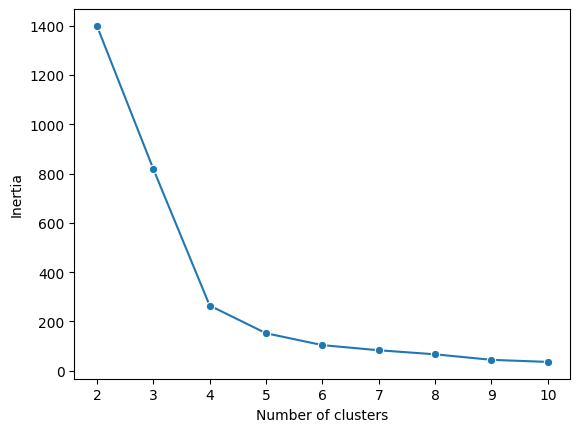

In [29]:
plot = sns.lineplot(x=num_clusters, y=inertia, marker ='o')
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")

#### Results and Evaluation

In [30]:
# Evaluate silhouette score
# Function to return a list of each k-value's score

def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[0.7299936597346783,
 0.5767443362136551,
 0.7398434063664576,
 0.7248799750151823,
 0.7235683639930051,
 0.7068848047130204,
 0.7036242429883977,
 0.7057727501903408,
 0.7034294396777961]

Create a line plot that shows the relationship between 'num_clusters' and 'silhoutte score'

Text(0, 0.5, 'Silhouette Score')

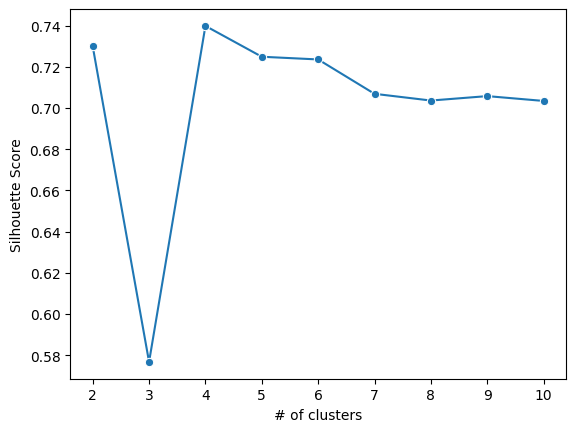

In [31]:
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters")
plot.set_ylabel("Silhouette Score")

#### Optimal k-value

In [32]:
# Fit a 4-cluster model
kmeans4 = KMeans(n_clusters= 4, random_state=42)
kmeans4.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

Print out the unique labels of the fit model

In [33]:
# Print unique labels
print('Unique labels:', np.unique(kmeans4.labels_))

Unique labels: [0 1 2 3]


Create a cluster column that indicates cluster assignment

In [34]:
# Create a cluster column
df_period_peak['cluster'] = kmeans4.labels_
df_period_peak.head()

,start_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster
0,2112 W Peterson Ave,865,993.323699,True,False,0
1,351,1,1024.000000,True,False,0
2,63rd St Beach,1429,1422.706088,True,False,0
3,900 W Harrison St,7913,688.889170,True,False,0
4,Aberdeen St & Jackson Blvd,11725,689.440597,True,False,2


#### Plot the clusters

In [35]:
# The each station's position (latitude and longitude)
station_post = df.groupby('start_station_name').agg({'start_lat':['mean'], 'start_lng':['mean']}).reset_index()
station_post.columns = station_post.columns.droplevel()
station_post.rename(columns={'':'start_station_name'}, inplace=True)
station_post.columns.values[[1,2]] = ['start_lat','start_lng']

# Merge with the cluster dataframe
df_station_post = df_period_peak.merge(station_post, left_on = 'start_station_name', right_on='start_station_name', how='left')
df_station_post.head(2)

,start_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster,start_lat,start_lng
0,2112 W Peterson Ave,865,993.323699,True,False,0,41.991175,-87.683592
1,351,1,1024.000000,True,False,0,41.930000,-87.780000


In [36]:
def cluster(num):

    # Filter
    df = df_station_post[df_station_post['cluster'] == num].reset_index(drop=True)

    return df

# Filter clusters
df_cluster0 = cluster(0)
df_cluster1 = cluster(1)
df_cluster2 = cluster(2)
df_cluster3 = cluster(3)

In [37]:
# Group the cluster to see number of stations in each cluster and the total number of rides from each station
df_station_post.groupby('cluster').agg({'ride_count':['sum','count']})

ride_count      
               sum count
cluster                 
0          1237824   524
1            88170    50
2          2947627   167
3           114942    93

#### Colour Legend
- Beige - Cluster 0
- Dark Green - Cluster 1
- Red - Cluster 2
- Blue - CCluster 3

In [38]:
# Plot
mapit = folium.Map(location = [df['start_lat'].mean(), df['start_lng'].mean()], zoom_start=10)

for i in range(0,50):
    # Cluster O plot
    folium.Marker(location = [df_cluster0.iloc[i]['start_lat'], df_cluster0.iloc[i]['start_lng']],
                  icon = folium.Icon(color='beige'), 
                  popup=df_cluster0.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 1 plot
    folium.Marker(location = [df_cluster1.iloc[i]['start_lat'], df_cluster1.iloc[i]['start_lng']],
                  icon = folium.Icon(color='darkgreen'), 
                  popup=df_cluster1.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 2 plot
    folium.Marker(location = [df_cluster2.iloc[i]['start_lat'], df_cluster2.iloc[i]['start_lng']],
                  icon = folium.Icon(color='red'), 
                  popup=df_cluster2.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 3 plot
    folium.Marker(location = [df_cluster3.iloc[i]['start_lat'], df_cluster3.iloc[i]['start_lng']],
                  icon = folium.Icon(color='blue'), 
                  popup=df_cluster3.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
   
# Show viz
mapit
    

### END STATION CLUSTERING

#### Feature Selection

In [39]:
cluster_end_df = df.drop(['started_at','start_station_name','rideable_type','ended_at','start_station_id',
                      'end_station_id','start_lat','start_lng','end_lat', 'end_lng','start_time','member_casual', 'month'],
                      axis = 1)
cluster_end_df.head(2)

,ride_id,end_station_name,day,end_time,ride_duration
0,BD0A6FF6FFF9B921,St. Clair St & Erie St,Sunday,13:45:40,580.0
1,96A7A7A4BDE4F82D,Noble St & Milwaukee Ave,Sunday,10:14:45,679.0


#### Feature Extraction

In [40]:
# Define function to assign peak times from start time

def day_period(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

# Apply the function to the 'start_time' column
cluster_end_df['time_of_day'] = cluster_end_df['end_time'].apply(day_period)

# find the count of each time of day
cluster_end_df['time_of_day'].value_counts()

time_of_day
Afternoon    1889916
Night        1319968
Morning      1178679
Name: count, dtype: int64

#### Feature Transformation

In [41]:
cluster_end_df['daily_period'] = cluster_end_df['time_of_day'].map(daily_period)

# Get each stations peak period in a day
df_day = cluster_end_df.groupby(['end_station_name','daily_period']).agg({'ride_id':['count']}).reset_index()
df_day.columns = df_day.columns.droplevel()
df_day.rename(columns={'':'end_station_name'}, inplace=True)
df_day.columns.values[[1,2]] = ['peak_daily_period','day_ride_count']

df_day_ride = df_day.loc[df_day.groupby('end_station_name')['day_ride_count'].idxmax()].reset_index(drop=True)
df_day_ride.drop(columns=['day_ride_count'], inplace=True)

# Get the number of rides and the average ride duration of rides from each station
df_cluster = cluster_end_df.groupby('end_station_name').agg({'ride_id':['count'], 'ride_duration':['mean']}).reset_index()
df_cluster.columns = df_cluster.columns.droplevel()
df_cluster.rename(columns={'':'end_station_name'}, inplace=True)
df_cluster.columns.values[[1,2]] = ['ride_count','avg_ride_duration']

# Merge
df_day_cluster = df_cluster.merge(df_day_ride, left_on = 'end_station_name', right_on='end_station_name', how= 'left')

#### Encode Data

In [42]:
# Convert 'peak daily period' categorical columns to numeric
df_period_peak = pd.get_dummies(df_day_cluster, drop_first=True, columns = ['peak_daily_period'])
df_period_peak.head()

,end_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2
0,2112 W Peterson Ave,991,961.843592,True,False
1,63rd St Beach,1500,1378.999333,True,False
2,900 W Harrison St,8005,665.079200,True,False
3,Aberdeen St & Jackson Blvd,11629,671.358070,True,False
4,Aberdeen St & Monroe St,10870,761.581509,True,False


#### Scale Features

In [43]:
# Exclude columns
X = df_period_peak.drop(['end_station_name','avg_ride_duration'], axis=1)

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

#### Data Modelling

In [44]:
# Fit K-means and evaluate inertia for differnt values of k

num_clusters = [i for i in range(2,11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

# Return a list of inertia for k=2 to 10
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[1298.7152264218778,
 747.7294882896787,
 313.8326179882508,
 201.0056802002989,
 151.734978033554,
 110.68570268921107,
 88.91938487395053,
 66.20064303332542,
 52.13400513039058]

Text(0, 0.5, 'Inertia')

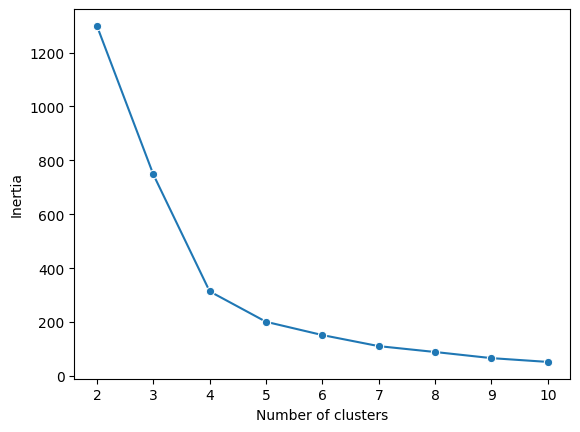

In [45]:
plot = sns.lineplot(x=num_clusters, y=inertia, marker ='o')
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")

#### Results and Evaluation

In [46]:
# Evaluate silhouette score
# Function to return a list of each k-value's score

def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[0.6537963952885328,
 0.5900268077079589,
 0.7255615857026222,
 0.7114650828144193,
 0.7237741010748096,
 0.7200422484025112,
 0.7091629125832835,
 0.7028582145313396,
 0.7031701326379584]

Text(0, 0.5, 'Silhouette Score')

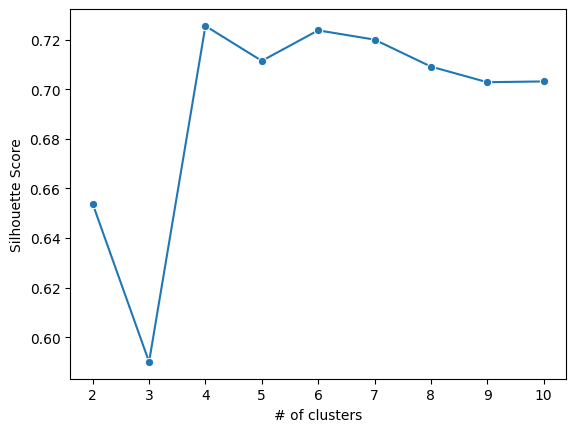

In [47]:
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters")
plot.set_ylabel("Silhouette Score")

#### Optimal k-value

In [48]:
# Fit a 4-cluster model
kmeans4 = KMeans(n_clusters= 4, random_state=42)
kmeans4.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

In [49]:
# Create a cluster column
df_period_peak['cluster'] = kmeans4.labels_
df_period_peak.head()

,end_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster
0,2112 W Peterson Ave,991,961.843592,True,False,1
1,63rd St Beach,1500,1378.999333,True,False,1
2,900 W Harrison St,8005,665.079200,True,False,1
3,Aberdeen St & Jackson Blvd,11629,671.358070,True,False,2
4,Aberdeen St & Monroe St,10870,761.581509,True,False,2


#### Plot the cluster

In [50]:
# The each station's position (latitude and longitude)
station_post = df.groupby('end_station_name').agg({'end_lat':['mean'], 'end_lng':['mean']}).reset_index()
station_post.columns = station_post.columns.droplevel()
station_post.rename(columns={'':'end_station_name'}, inplace=True)
station_post.columns.values[[1,2]] = ['end_lat','end_lng']

# Merge with the cluster dataframe
df_station_post = df_period_peak.merge(station_post, left_on = 'end_station_name', right_on='end_station_name', how='left')
df_station_post.head(2)

,end_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster,end_lat,end_lng
0,2112 W Peterson Ave,991,961.843592,True,False,1,41.991135,-87.683575
1,63rd St Beach,1500,1378.999333,True,False,1,41.781049,-87.576256


In [51]:
def cluster(num):

    # Filter
    df = df_station_post[df_station_post['cluster'] == num].reset_index(drop=True)

    return df

# Filter clusters
df_cluster0 = cluster(0)
df_cluster1 = cluster(1)
df_cluster2 = cluster(2)
df_cluster3 = cluster(3)
df_cluster4 = cluster(4)

In [52]:
# Group the cluster to see number of stations in each cluster and the total number of rides from each station
df_station_post.groupby('cluster').agg({'ride_count':['sum','mean','count']})

ride_count                    
               sum          mean count
cluster                               
0           227752   2148.603774   106
1          1063991   2298.036717   463
2          2765477  17841.787097   155
3           331343   3067.990741   108

#### Colour Legend
- Dark Green - Cluster 0
- Beige - Cluster 1
- Red - Cluster 2
- Blue - CCluster 3

In [53]:
# Plot
mapit = folium.Map(location = [df['end_lat'].mean(), df['end_lng'].mean()], zoom_start=10)

for i in range(0,50):
    # Cluster O plot
    folium.Marker(location = [df_cluster0.iloc[i]['end_lat'], df_cluster0.iloc[i]['end_lng']],
                  icon = folium.Icon(color='darkgreen'), 
                  popup=df_cluster0.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 1 plot
    folium.Marker(location = [df_cluster1.iloc[i]['end_lat'], df_cluster1.iloc[i]['end_lng']],
                  icon = folium.Icon(color='beige'), 
                  popup=df_cluster1.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 2 plot
    folium.Marker(location = [df_cluster2.iloc[i]['end_lat'], df_cluster2.iloc[i]['end_lng']],
                  icon = folium.Icon(color='red'), 
                  popup=df_cluster2.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 3 plot
    folium.Marker(location = [df_cluster3.iloc[i]['end_lat'], df_cluster3.iloc[i]['end_lng']],
                  icon = folium.Icon(color='blue'), 
                  popup=df_cluster3.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
# Show viz
mapit
    

## Summary